In [1]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import pickle5 as pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
import seaborn as sns

from pylab import *
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte

In [2]:
def generate_dashboard_data(saved_data=True, data_path=None, data=None, 
                            saved_predictions=True, predictions_path=None, predictions=None):
    """Helper function that generates dataframe and dictionary
       needed for dashboard of results
       
       :param saved_data: -> bool | whether data being loaded is saved pkl file or a dataframe
       :param data_path: -> str | where the data pkl file is located, if using saved file
       :param data: -> dataframe of data, if not using saved file
       :param saved_predictions: -> bool | whether predictions being loaded is saved pkl file or dataframe
       :param predictions_path: -> str | where the predictions pkl file is located, if using saved file
       :param predictions: -> list of lists containing model predictions (see model pipeline for format)
       
       Ouputs:
       - data dataframe augmented with prediction labels + probabilities 
         and second prediction labels + probabilities
       - dictionary of counts of predicted defective wafers per lot"""
    
    if saved_data:
        # load data
        with open('../../data/customer/WM-unlabeled-random50-0.pkl', "rb") as fh:
            data = pickle.load(fh)
    
    if saved_predictions:
        # load predictions
        with open('../results/yutandem-224thin2-unlabeled-random0.pkl', "rb") as fh:
            predictions = pickle.load(fh)
    
    # unpack predictions
    defect_ids = predictions[0]
    detect_probs = predictions[1]
    classify_probs = predictions[2]
    labels = predictions[3]
    
    # probabilities for the highest class for each model
    detect_max_prob = [max(x) for x in detect_probs]
    classify_max_prob = [max(x) for x in classify_probs]

    # second highest class for defective sample
    classify_label2 = [x.argsort()[-2] for x in classify_probs]

    # second highest class probability
    classify_max_prob2 = [x[i] for x, i in zip(classify_probs, classify_label2)]
    
    # add columns to dataframe
    data['pred_labels'] = labels

    # add column of probabilities predicted class 
    def add_max_prob(row):
        i = row.name
        if row['pred_labels'] == 8:
            return detect_max_prob[i] * 100
        else:
            j = defect_ids.index(data.ID[i])
            return (detect_max_prob[i] * classify_max_prob[j]) * 100

    data['pred_prob'] = data.apply(lambda row: add_max_prob(row), axis=1)

    # add column for second prediction, if defective
    # if not defective, second prediction = 8
    def second_prediction(row):
        i = row.name
        if row['pred_labels'] == 8:
            return 8
        else:
            j = defect_ids.index(data.ID[i])
            return classify_label2[j]

    data['pred2_labels'] = data.apply(lambda row: second_prediction(row), axis=1)

    # add column of probabilities for second highest class, if defective
    # if not defective, second probability = 0
    def add_second_prob(row):
        i = row.name
        if row['pred_labels'] == 8:
            return 0
        else:
            j = defect_ids.index(data.ID[i])
            return (detect_max_prob[i] * classify_max_prob2[j]) * 100

    data['pred2_prob'] = data.apply(lambda row: add_second_prob(row), axis=1)
    
    print(f'Augmented results dataset shape: {data.shape}')
    
    # count how many defective wafers in each lot
    # list of unique lots
    unique_lots = data.lotName.unique()

    lot_count = {x:0 for x in unique_lots}
    for i in range(len(data)):
        if data.pred_labels[i] != 8:
            lot_count[data.lotName[i]] += 1
    
    print(f'Number of lots in lot count dictionary: {len(lot_count)}')
    
    return data, lot_count

In [3]:
data_path = '../../data/customer/WM-unlabeled-random50-0.pkl'
predictions_path = '../results/yutandem-224thin2-unlabeled-random0.pkl'

data, lot_count = generate_dashboard_data(data_path=data_path, predictions_path=predictions_path)
data.head()

Augmented results dataset shape: (1250, 9)
Number of lots in lot count dictionary: 50


,ID,waferMap,dieSize,lotName,waferIndex,pred_labels,pred_prob,pred2_labels,pred2_prob
0,4387,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",904,lot1976,1,1,27.834025,0,24.476160
1,4388,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",904,lot1976,2,1,94.864613,0,1.291329
2,4389,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",904,lot1976,3,8,99.999821,8,0.000000
3,4390,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",904,lot1976,4,8,99.988449,8,0.000000
4,4391,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",904,lot1976,5,8,90.972817,8,0.000000


In [4]:
def defect_distribution(data, note='', mode='all', color=None):
    """Helper function to visualize distribution of defects
       :param mode -> str | classify or detect"""
    
    if mode == 'detect':
        data['detectLabels'] = data.pred_labels.apply(lambda x: 0 if x == 8 else 1)
        col = 'detectLabels'
    else:
        col = 'pred_labels'
        if mode == 'classify':
            data = data[data.pred_labels != 8].reset_index(drop=True)    
    
    # count how many of each defect is present
    dist = data.groupby(col)[col].count().sort_values()
    y = dist.tolist()
    
    if mode == 'detect':
        x = ['None', 'Defect']
    else:
        fail_dict = {8: 'none', 0: 'Loc', 1: 'Edge-Loc', 2: 'Center', 3: 'Edge-Ring', 
                 4: 'Scratch', 5: 'Random', 6: 'Near-full', 7: 'Donut'}
        indices = dist.index.tolist()
        x = [fail_dict[i] for i in indices]

    # bar plot
    if color:
        plt.barh(x, y, color=color)
    else:
        plt.barh(x, y)
        
    xlim = math.ceil(max(y)*1.15)
    plt.xlim(0, xlim)
    
    if mode == 'all':
        plt.title(f'Overall Failure Type Distribution\n({note})')
    elif mode == 'classify':
        plt.title(f'Defect Distribution\n({note})')
    elif mode == 'detect':
        plt.title(f'None vs Defect Distribution\n({note})')

    for index, value in enumerate(y):
        plt.text(value, index,
                 str(value))

    plt.show()

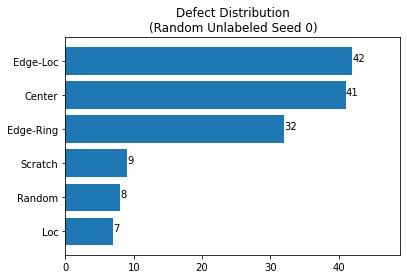

In [5]:
# distribution of labels
defect_distribution(data, note='Random Unlabeled Seed 0', mode='classify')

In [18]:
def visualize_defective_lots(lot_count, cmap='viridis', white=True):
    """Helper function that creates a pie chart based on 
       the number of predicted defective wafers in each lot
       
       :param lot_count: -> dictionary of counts of predicted defective wafers per lot
       :param cmap: -> color scheme for pie chart
       :param white: -> bool | whether the autotext in the pie chart is white or black"""
    
    tiers = ['No Defects', '< 10 Defects', '< 20 Defects', '20+ Defects']
    defect_count = {x:0 for x in tiers}
    for key, value in lot_count.items():
        if value == 0:
            defect_count['No Defects'] += 1
        elif value < 20:
            defect_count['< 20 Defects'] += 1
        elif value >= 20:
            defect_count['20+ Defects'] += 1

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [x for x in defect_count.keys() if defect_count[x] > 0]
    sizes = [defect_count[x] for x in defect_count.keys() if defect_count[x] > 0]

    fig1, ax1 = plt.subplots()
    theme = plt.get_cmap(cmap)
    ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
    total = sum(sizes)
    patches, texts, autotexts = ax1.pie(sizes, labels=labels, startangle=90,
                                        autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # [text.set_color('red') for text in texts]
    # texts[0].set_color('blue')
    if white:
        [autotext.set_color('white') for autotext in autotexts]
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

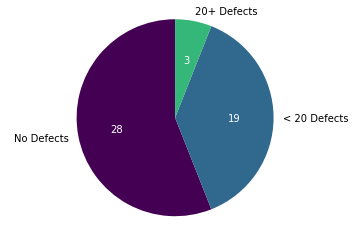

In [19]:
visualize_defective_lots(lot_count)

In [8]:
def plot_lot(df1, lot, fig_size=(10, 10), col='waferMap', cmap_img='gray_r', box_color='gray',
             resize=False, img_dims=[224,224], pct_color=True, cmap_pct='magma_r'):
    """
    Helper function to plot entire lot of wafers from df1.
    Lots must have >= 2 samples.
    
    :param lot: -> str | lotName that will be plotted e.g. 'lot1'
    :param fig_size: -> tuple | size of plot
    :param col: -> str | column that contains waferMap image
    :param cmap_img: -> str | color scheme to use on image plot
    :param box_color: -> str | color of box identifying defective wafers
    :param resize: -> bool | whether or not to apply resize to figure
    :param img_dims: -> resize dimensions
    :param pct_color: -> bool | whether or not to change the font color of the labels based on probability
    :param cmap_pct: -> str | color scheme to use on font color, if changing based on probability
    """
    
    lot_df = df1[df1['lotName'] == lot]
    lot_df.set_index('waferIndex', inplace=True)

    total_rows = 25
    ax_cnt = 5
    
    print(f'{lot}')
    
    fail_dict = {8:'None', 0:'Loc', 1:'Edge-Loc', 2:'Center', 3:'Edge-Ring', 
             4:'Scratch', 5:'Random', 6:'Near-full', 7:'Donut'}

    fig, axs = plt.subplots(5, 5, figsize=fig_size)
    fig.tight_layout()

    # Nested for loops to loop through all digits and number of examples input for plotting
    for n_row in range(25):

        img = lot_df[col][n_row+1]
        if resize:
            img = img_as_ubyte(sk_resize(img, img_dims, anti_aliasing=True))
        index = lot_df["ID"][n_row+1]
        ftype = fail_dict[lot_df.pred_labels[n_row+1]]
        pct = lot_df.pred_prob[n_row+1]

        # imshow to plot image in axs i,j location in plot
        j = n_row % 5
        i = int(n_row/5)
        axs[i, j].imshow(img,
                         interpolation='none',
                         cmap=cmap_img)
        axs[i, j].axis('off')
        
        if ftype != 'None':
            autoAxis = axs[i, j].axis()
            rec = Rectangle((autoAxis[0],autoAxis[2]),
                            (autoAxis[1]-autoAxis[0]),
                            (autoAxis[3]-autoAxis[2]),
                            fill=False, lw=1, color=box_color)
            rec = axs[i, j].add_patch(rec)
            rec.set_clip_on(False)

        # label the figure with the index# and defect classification 
        # change font color based on probability
        
        def color_map_color(value, cmap_name=cmap_pct, vmin=0, vmax=100):
            norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap(cmap_name)  # PiYG
            rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
            color = matplotlib.colors.rgb2hex(rgb)
            return color
        
        if pct_color:
            color = color_map_color(pct)
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=12, 
                                fontweight="bold", color=color)
        else:
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=12, fontweight="bold")

    plt.show()

lot1976


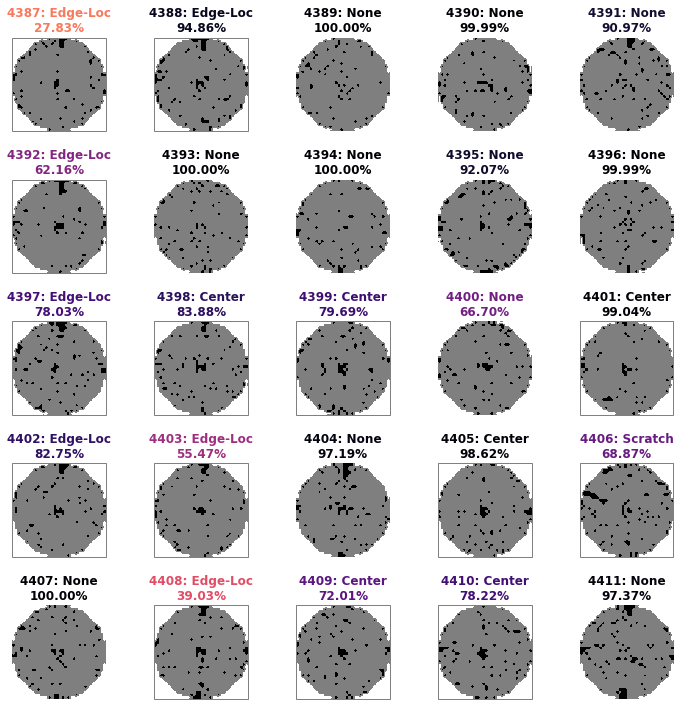

In [9]:
plot_lot(data, 'lot1976', resize=True)

lot2541


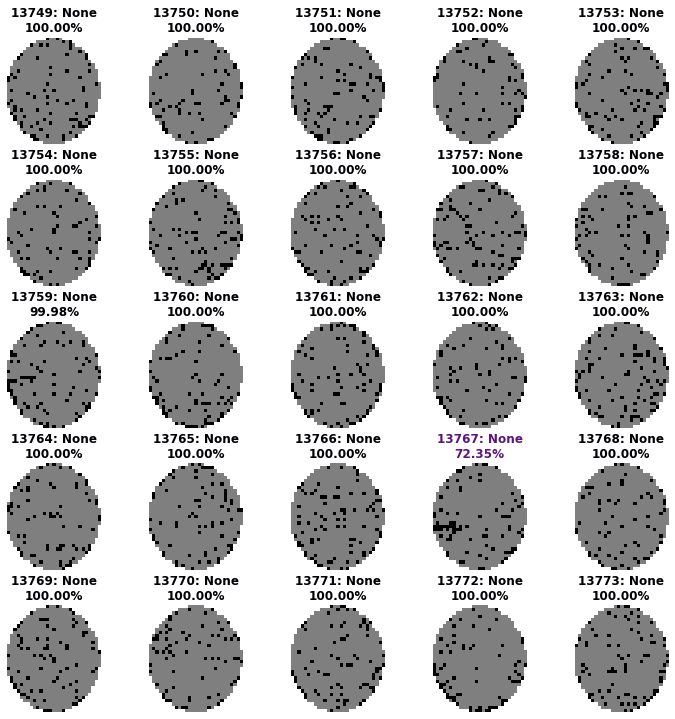

In [10]:
plot_lot(data, 'lot2541', resize=False)

lot11586


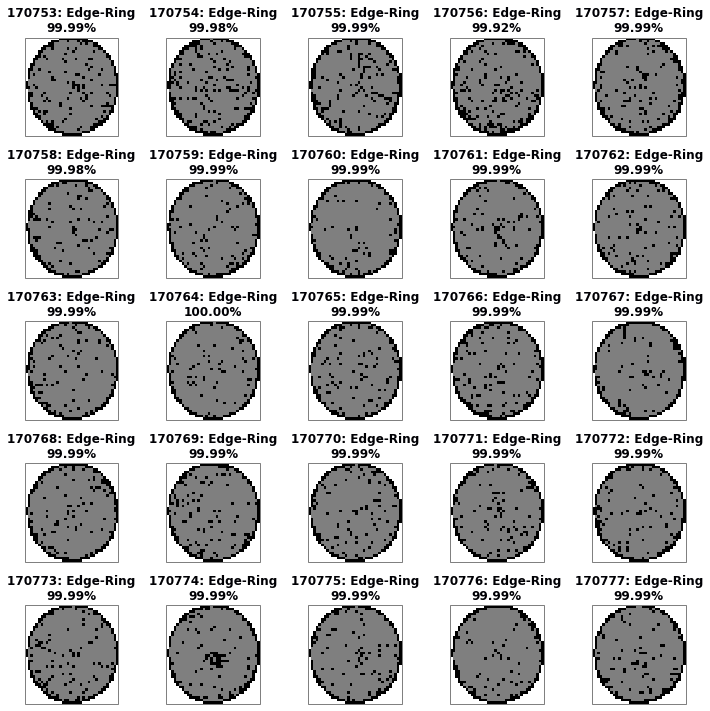

In [11]:
plot_lot(data, 'lot11586', resize=False)

In [12]:
def plot_list(df1, wafer_list, fig_size=(10, 10), col='waferMap', cmap_img='gray_r', mode='index', box_color='gray',
              resize=False, img_dims=[224,224], pct_color=True, cmap_pct='magma_r'):
    """
    Helper function to plot a list of indices from df1.
    Lots must have >= 2 samples.
    
    :param wafer_list: -> list | list of indices or ids to be plotted
    :param fig_size: -> tuple | size of plot
    :param col: -> str | column that contains waferMap image
    :param cmap_img: -> str | color scheme to use on image plot
    :param mode: -> str | 'index' or 'id'
    :param box_color: -> str | color of box identifying defective wafers
    :param resize: -> bool | whether or not to apply resize to figure
    :param img_dims: -> resize dimensions
    :param pct_color: -> bool | whether or not to change the font color of the labels based on probability
    :param cmap_pct: -> str | color scheme to use on font color, if changing based on probability
    """

    if mode == 'index':
        index_list = wafer_list
    elif mode == 'id':
        index_list = [df1.index[df1.ID == i][0] for i in wafer_list]
    
    list_df = df1.loc[index_list, :]
    list_df.reset_index(inplace=True)

    total_rows = len(list_df.index)
    ax_cnt = int(math.ceil(total_rows**(1/2)))
    
    fail_dict = {8:'None', 0:'Loc', 1:'Edge-Loc', 2:'Center', 3:'Edge-Ring', 
             4:'Scratch', 5:'Random', 6:'Near-full', 7:'Donut'}
    
    fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=fig_size)
    fig.tight_layout()

    # Nested for loops to loop through all digits and number of examples input for plotting
    for n_row in range(ax_cnt**2):
        if n_row < total_rows:
            img = list_df[col][n_row]
            if resize:
                img = img_as_ubyte(sk_resize(img, img_dims, anti_aliasing=True))
            index = list_df["ID"][n_row]
            ftype = fail_dict[list_df.pred_labels[n_row]]
            pct = list_df.pred_prob[n_row]
                
        else:
            img = np.zeros_like(list_df[col][0])
            index = ''
            ftype = ''
            pct = ''

        # imshow to plot image in axs i,j location in plot
        j = n_row % ax_cnt
        i = int(n_row/ax_cnt)
        axs[i, j].imshow(img,
                         interpolation='none',
                         cmap=cmap_img)
        axs[i, j].axis('off')
        
        if ftype != 'None':
            autoAxis = axs[i, j].axis()
            rec = Rectangle((autoAxis[0], autoAxis[2]),
                            (autoAxis[1]-autoAxis[0]),
                            (autoAxis[3]-autoAxis[2]),
                            fill=False, lw=1, color=box_color)
            rec = axs[i, j].add_patch(rec)
            rec.set_clip_on(False)

        # label the figure with the index# and defect classification 
        # change font color based on probability
        
        def color_map_color(value, cmap_name=cmap_pct, vmin=0, vmax=100):
            norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap(cmap_name)  # PiYG
            rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
            color = matplotlib.colors.rgb2hex(rgb)
            return color
        
        if pct_color:
            color = color_map_color(pct)
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=12, 
                                fontweight="bold", color=color)
        else:
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=12, fontweight="bold")


    plt.show()

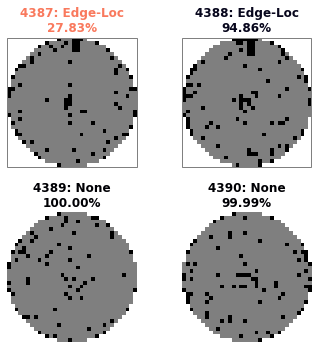

In [13]:
plot_list(data, [4387, 4388, 4389, 4390], mode='id', fig_size=(5,5))

In [14]:
def plot_lot_probs(df1, lot, cmap='cividis_r'):
    """
    Helper function to plot heatmap of model prediction probabilities for a lot
    
    :param lot: -> str | lotName that will be plotted e.g. 'lot1'
    :param fig_size: -> tuple | size of plot
    :param col: -> str | column that contains waferMap image
    :param cmap: -> str | color scheme to use
    """
       
    lot_df = df1[df1['lotName'] == lot]
    lot_df.set_index('waferIndex', inplace=True)
    
    # collect probabilities into a 5x5 array
    arr1 = np.array([lot_df.pred_prob[i] for i in [1, 2, 3, 4, 5]])
    arr2 = np.array([lot_df.pred_prob[i] for i in [6, 7, 8, 9, 10]])
    arr3 = np.array([lot_df.pred_prob[i] for i in [11, 12, 13, 14, 15]])
    arr4 = np.array([lot_df.pred_prob[i] for i in [16, 17, 18, 19, 20]])
    arr5 = np.array([lot_df.pred_prob[i] for i in [21, 22, 23, 24, 25]])
    probs = np.array([arr1, arr2, arr3, arr4, arr5])
   
    print(f'{lot}')
    
    f = sns.heatmap(probs, annot=True, cmap=cmap,
                    xticklabels=False, yticklabels=False, fmt='.2f')

lot1976


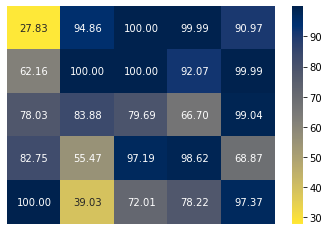

In [15]:
plot_lot_probs(data, 'lot1976')